# Import Library

In [1]:
import numpy as np
import pandas as pd
from datetime import date, timedelta
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import skew, kurtosis

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras import layers,Sequential,losses,optimizers,datasets

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

def setup_seed(seed):
    random.seed(seed)  # 为python设置随机种子
    np.random.seed(seed)  # 为numpy设置随机种子
    tf.random.set_seed(seed)  # tf cpu fix seed
    os.environ['TF_DETERMINISTIC_OPS'] = '1'  # tf gpu fix seed, please `pip install tensorflow-determinism` first

setup_seed(2020)


seed = 2020
random.seed = 2020
np.random.seed = 2020
tf.seed = 2020
tf.random.set_seed(2020)

# Data processing

In [2]:
import scipy.io as scio
import pandas as pd

#input
feature1 = r'\Training dataset\ACC_UD.mat'
data1 = scio.loadmat(feature1)
AA=data1['ACC_UD']
A=AA[:,0:300]

feature2 = r'\Training dataset\ACC_EW.mat'
data2 = scio.loadmat(feature2)
BB=data2['ACC_EW']
B=BB[:,0:300]

feature3 = r'\Training dataset\ACC_NS.mat'
data3 = scio.loadmat(feature3)
CC=data3['ACC_NS']
C=CC[:,0:300]




label = pd.read_csv(open(r'\Training dataset\lable.csv',encoding='UTF-8'))


In [3]:
raw_data1=np.hstack((A,B))
train_xx=np.hstack((raw_data1,C))

#print(train_xx.shape)


train_y=label.iloc[:,[0]].values  #知识嵌入
#y_data=label.iloc[:,[12]].values    #导入数据  iloc通过行号获取行数据
#print(train_y[0])
#print(train_y.shape)

In [4]:
train_x=[]
for i in range(len(train_xx)):
    train_x.append(np.array(train_xx[i].reshape(3,1,300)).T)

In [5]:
train_x=np.array(train_x)
#test_x=np.array(test_x)

In [6]:
#3#  ##Reshaping
train_x = np.reshape(train_x, (train_x.shape[0], 300, 3))
#test_x = np.reshape(test_x, (test_x.shape[0], 300, 9))
#print("0",train_x.shape[0])
#print("1",train_x.shape[1])
#print(train_x.shape)
#print(train_x)

# CNN-Dis architecture, training and testing

In [7]:
from keras import backend as K
from keras.engine.topology import Layer
class Self_Attention(Layer):
 
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(Self_Attention, self).__init__(**kwargs)
 
    def build(self, input_shape):
        # 为该层创建一个可训练的权重
        #inputs.shape = (batch_size, time_steps, seq_len)
        self.kernel = self.add_weight(name='kernel',
                                      shape=(3,input_shape[2], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
 
        super(Self_Attention, self).build(input_shape)  # 一定要在最后调用它
 
    def call(self, x):
        WQ = K.dot(x, self.kernel[0])
        WK = K.dot(x, self.kernel[1])
        WV = K.dot(x, self.kernel[2])
 
        print("WQ.shape",WQ.shape)
 
        print("K.permute_dimensions(WK, [0, 2, 1]).shape",K.permute_dimensions(WK, [0, 2, 1]).shape)
 
 
        QK = K.batch_dot(WQ,K.permute_dimensions(WK, [0, 2, 1]))
 
        QK = QK / (64**0.5)
 
        QK = K.softmax(QK)
 
        print("QK.shape",QK.shape)
 
        V = K.batch_dot(QK,WV)
 
        return V
 
    def compute_output_shape(self, input_shape):
 
        return (input_shape[0],input_shape[1],self.output_dim)

    def get_config(self):  #在有自定义网络层时，需要保存模型时，重写get_config函数
        config = {"output_dim": self.output_dim}
        base_config = super(Self_Attention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [8]:
seed=50
#50 17.20 1.32
drop_rate = 0.2
def get_model():

    inp1 = Input(shape=(300, 3), name='input_layer') 

    e = Conv1D(128, 3, padding = 'same')(inp1) 
    e = ReLU()(e)
    e = MaxPooling1D(4, padding='same')(e)
# 
    e = Conv1D(128, 3, padding = 'same')(e) 
    e = ReLU()(e)
    e = MaxPooling1D(4, padding='same')(e)

    e = Conv1D(128, 3, padding = 'same')(e) 
    e = ReLU()(e)
    e = MaxPooling1D(4, padding='same')(e)
    
    e = Conv1D(128, 3, padding = 'same')(e) 
    e = ReLU()(e)
    e = MaxPooling1D(4, padding='same')(e)

    e = Conv1D(128, 3, padding = 'same')(e) 
    e = ReLU()(e)
    e = MaxPooling1D(4, padding='same')(e)
    
    
    e = Flatten()(e)


    e = Dense(1)(e)
    o = Activation('linear', name='output_layer')(e)
    

    #model = Model([inp_seq, inp_lap, inp_feat], out)  ,inpt2
    rms = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model = Model(inp1, o)
    model.compile(optimizer = rms, loss = 'mean_squared_error')

    return model

In [9]:
model = get_model()
model.summary() 

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 300, 3)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 300, 128)          1280      
_________________________________________________________________
re_lu (ReLU)                 (None, 300, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 75, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 75, 128)           49280     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 75, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 19, 128)          

In [10]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
lr_reducer = ReduceLROnPlateau(monitor="val_loss",
                               factor=0.1,
                                cooldown= 0,
                                patience= 5,
                                min_lr=0.1e-7)
early_stopping_monitor = EarlyStopping(monitor= 'val_loss', patience = 10) #10  17.20 1.32
callbacks = [lr_reducer, early_stopping_monitor]




model = get_model()
model.fit(train_x, train_y, epochs=300, batch_size=256,  
            validation_split=0.1, callbacks=callbacks)  #256 ,train_physics  ,test_physics ,train_physics

pred_train_all = model.predict(train_x).ravel()
#pred_test_all = model.predict(test_x).ravel()  ##ravel() 转换成1列


#pred_valid_all = scaler_seq.inverse_transform(pred_valid_all)
#reverse_valid = scaler_seq.inverse_transform(y_valid)
#pred_test_all = scaler_seq.inverse_transform(pred_test_all)
#reverse_test = scaler_seq.inverse_transform(y_test)

Epoch 1/300
162/162 [==============================] - 1063s 7s/step - loss: 3549.2998 - val_loss: 1957.1956
Epoch 2/300
162/162 [==============================] - 6s 38ms/step - loss: 1455.1802 - val_loss: 1435.6936
Epoch 3/300
162/162 [==============================] - 6s 39ms/step - loss: 1296.1968 - val_loss: 1391.5488
Epoch 4/300
162/162 [==============================] - 6s 39ms/step - loss: 1221.0795 - val_loss: 1409.7998
Epoch 5/300
162/162 [==============================] - 6s 38ms/step - loss: 1164.3798 - val_loss: 1224.3315
Epoch 6/300
162/162 [==============================] - 6s 38ms/step - loss: 1077.1304 - val_loss: 1118.8475
Epoch 7/300
162/162 [==============================] - 6s 37ms/step - loss: 1005.6443 - val_loss: 1138.8071
Epoch 8/300
162/162 [==============================] - 6s 38ms/step - loss: 958.4373 - val_loss: 1081.1179
Epoch 9/300
162/162 [==============================] - 6s 39ms/step - loss: 910.4532 - val_loss: 988.4298
Epoch 10/300
162/162 [========

In [11]:
# 保存权重（推荐方式）
model.save_weights("CNN_Dis_weights.h5")  # HDF5格式

In [12]:
def get_model_size_mb(model):
    params = model.count_params()
    # 假设所有参数为float32（4字节）
    size_mb = params * 4 / 1024**2
    return size_mb
 
print("Model size (MB):", get_model_size_mb(model))


Model size (MB): 0.7573280334472656


训练标准差STD= 0.1718748661948245
训练误差均值MEAN= 0.03172442035522854
训练平均绝对误差MAE= 0.12860172984740662
训练RMSE= 0.17477816933577278
训练MAPE= 14.129995229024045
训练r2 score: 0.754138582957786


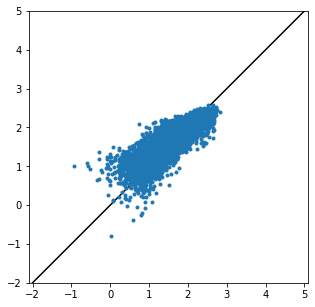

In [13]:
from sklearn import metrics
from sklearn.metrics import r2_score

pred_train_all[pred_train_all <= 0] = 10
train_y=np.log10(train_y) 
pred_train_all=np.log10(pred_train_all)

print("训练标准差STD=",np.std(pred_train_all-train_y.ravel()))
print("训练误差均值MEAN=",np.mean(pred_train_all-train_y.ravel()))
print("训练平均绝对误差MAE=",metrics.mean_absolute_error(pred_train_all, train_y.ravel()))
print("训练RMSE=",metrics.mean_squared_error(pred_train_all, train_y.ravel())**0.5)
print("训练MAPE=",np.mean(np.abs((train_y.ravel() - pred_train_all) / train_y.ravel())) * 100)
print("训练r2 score:", r2_score(train_y.ravel(), pred_train_all))


plt.figure(figsize=(5, 5))
plt.axis('equal')

x3 = np.arange(-2, 5, 0.01)
y3=x3
plt.plot(x3, y3, "black")
plt.plot(train_y.ravel(),pred_train_all,'.')
plt.xlim(-2, 5)
plt.ylim(-2, 5)
plt.show()

In [14]:
#########################保存训练结果####################################
pred_train_all=pred_train_all.reshape(pred_train_all.shape[0],1)

#y_score_tr=y_score_tr.reshape(y_score_tr.shape[0],1)
#print(pred_train_all.shape)
#print(train_y.shape)

tr_result=np.concatenate((train_y,pred_train_all),axis=1)

#print(tr_result.shape)

data_tr = pd.DataFrame(tr_result) #将数组转换为dataframe结构
data_tr.columns=['True LGED','Pred LGED']
writer_tr = pd.ExcelWriter(r'\CNN-Dis\distrain.xls')   # 写入Excel文件

data_tr.to_excel(writer_tr,float_format='%.5f',index=False)   ## ‘page_1’是写入excel的sheet名
writer_tr.save()
writer_tr.close()
#########################保存训练结果####################################

In [15]:
#震例
import scipy.io as scio
import pandas as pd

#input
feature1z = r'\Test dataset\ACC_UD.mat'
data1z = scio.loadmat(feature1z)
AAz=data1z['ACC_UD']
Az=AAz[:,0:300]

feature2z = r'\Test dataset\ACC_EW.mat'
data2z = scio.loadmat(feature2z)
BBz=data2z['ACC_EW']
Bz=BBz[:,0:300]

feature3z = r'\Test dataset\ACC_NS.mat'
data3z = scio.loadmat(feature3z)
CCz=data3z['ACC_NS']
Cz=CCz[:,0:300]



labelz = pd.read_csv(open(r'\Test dataset\lable.csv',encoding='UTF-8'))


In [16]:
raw_data1z=np.hstack((Az,Bz))
x_dataz=np.hstack((raw_data1z,Cz))


y_dataz=labelz.iloc[:,[0]].values  #知识嵌入
#y_data=label.iloc[:,[12]].values    #导入数据  iloc通过行号获取行数据
#print(y_dataz[0])
#print(y_dataz.shape)

In [17]:
zhenli_y=y_dataz



In [18]:
zhenli_x=[]
for i in range(len(x_dataz)):
    zhenli_x.append(np.array(x_dataz[i].reshape(3,1,300)).T)

In [19]:
zhenli_x=np.array(zhenli_x)

In [20]:
zhenli_x = np.reshape(zhenli_x, (zhenli_x.shape[0], 300, 3))

In [20]:
zhenli_x1=zhenli_x[0]
zhenli_x1=zhenli_x1.reshape(1, 300, 3)
print(zhenli_x1.shape)


(1, 300, 3)


In [22]:
import time
start_time = time.perf_counter()  # 记录开始时间
pred_zhenli_all = model.predict(zhenli_x1).ravel()  ##ravel() 转换成1列
end_time = time.perf_counter()  # 记录结束时间
elapsed_time_ms = (end_time - start_time) * 1000  # 转换为毫秒
print(f"Elapsed time: {elapsed_time_ms:.2f} ms")

Elapsed time: 32.01 ms


In [21]:
pred_zhenli_all = model.predict(zhenli_x).ravel()  ##ravel() 转换成1列

震例标准差STD= 0.1876608526326431
震例误差均值MEAN= 0.019977759806279114
震例平均绝对误差MAE= 0.13966717845417806
震例RMSE= 0.18872124018691688
震例MAPE= 12.284334412939476
震例r2 score: 0.7341458552690505


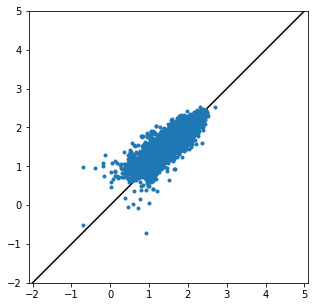

In [22]:
pred_zhenli_all[pred_zhenli_all <= 0] = 10
zhenli_y=np.log10(zhenli_y) 
pred_zhenli_all=np.log10(pred_zhenli_all)

print("震例标准差STD=",np.std(pred_zhenli_all-zhenli_y.ravel()))
print("震例误差均值MEAN=",np.mean(pred_zhenli_all-zhenli_y.ravel()))
print("震例平均绝对误差MAE=",metrics.mean_absolute_error(pred_zhenli_all, zhenli_y.ravel()))
print("震例RMSE=",metrics.mean_squared_error(pred_zhenli_all, zhenli_y.ravel())**0.5)
print("震例MAPE=",np.mean(np.abs((zhenli_y.ravel() - pred_zhenli_all) / zhenli_y.ravel())) * 100)
print("震例r2 score:", r2_score(zhenli_y.ravel(), pred_zhenli_all))


plt.figure(figsize=(5, 5))
plt.axis('equal')

x3 = np.arange(-2, 5, 0.01)
y3=x3
plt.plot(x3, y3, "black")
plt.plot(zhenli_y.ravel(),pred_zhenli_all,'.')
plt.xlim(-2, 5)
plt.ylim(-2, 5)
plt.show()  

In [23]:
#########################保存震例结果####################################
pred_zhenli_all=pred_zhenli_all.reshape(pred_zhenli_all.shape[0],1)

#print(pred_zhenli_all.shape)
#print(zhenli_y.shape)

tz_result=np.concatenate((zhenli_y,pred_zhenli_all),axis=1)

#print(tz_result.shape)

data_tz = pd.DataFrame(tz_result) #将数组转换为dataframe结构
data_tz.columns=['True LGED','Pred LGED']
writer_tz = pd.ExcelWriter(r'\CNN-Dis\distest.xls')   # 写入Excel文件

data_tz.to_excel(writer_tz,float_format='%.5f',index=False)   ## ‘page_1’是写入excel的sheet名
writer_tz.save()
writer_tz.close()
#########################保存震例结果####################################

# Test on the Chinese strong-ground motion data

In [24]:
#在中国地区应用
import scipy.io as scio
import pandas as pd

#input
feature1z_CH = r'\Chinese strong-ground motion test dataset\ACC_UD.mat'
data1z_CH = scio.loadmat(feature1z_CH)
AAz_CH=data1z_CH['ACC_UD']
Az_CH=AAz_CH[:,0:300]

feature2z_CH = r'\Chinese strong-ground motion test dataset\ACC_EW.mat'
data2z_CH = scio.loadmat(feature2z_CH)
BBz_CH=data2z_CH['ACC_EW']
Bz_CH=BBz_CH[:,0:300]

feature3z_CH = r'\Chinese strong-ground motion test dataset\ACC_NS.mat'
data3z_CH = scio.loadmat(feature3z_CH)
CCz_CH=data3z_CH['ACC_NS']
Cz_CH=CCz_CH[:,0:300]



labelz_CH = pd.read_csv(open(r'\Chinese strong-ground motion test dataset\lable.csv',encoding='UTF-8'))


In [25]:
raw_data1z_CH=np.hstack((Az_CH,Bz_CH))
x_dataz_CH=np.hstack((raw_data1z_CH,Cz_CH))


y_dataz_CH=labelz_CH.iloc[:,[0]].values  #知识嵌入
#y_data=label.iloc[:,[12]].values    #导入数据  iloc通过行号获取行数据
#print(y_dataz_CH[0])
#print(y_dataz_CH.shape)

In [26]:
zhenli_y_CH=y_dataz_CH


In [27]:
zhenli_x_CH=[]
for i in range(len(x_dataz_CH)):
    zhenli_x_CH.append(np.array(x_dataz_CH[i].reshape(3,1,300)).T)

In [28]:
zhenli_x_CH=np.array(zhenli_x_CH)

In [29]:
zhenli_x_CH = np.reshape(zhenli_x_CH, (zhenli_x_CH.shape[0], 300, 3))

In [30]:
pred_zhenli_all_CH = model.predict(zhenli_x_CH).ravel()  ##ravel() 转换成1列

震例标准差STD= 0.20091632750652874
震例误差均值MEAN= 0.05419524307218411
震例平均绝对误差MAE= 0.16303990597562845
震例RMSE= 0.20809732105523088
震例MAPE= 11.327958436955218
震例r2 score: 0.6414913041353327


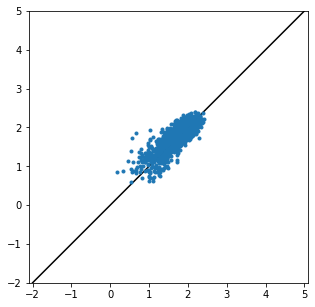

In [31]:
pred_zhenli_all_CH[pred_zhenli_all_CH <= 0] = 10
zhenli_y_CH=np.log10(zhenli_y_CH) 
pred_zhenli_all_CH=np.log10(pred_zhenli_all_CH)

print("震例标准差STD=",np.std(pred_zhenli_all_CH-zhenli_y_CH.ravel()))
print("震例误差均值MEAN=",np.mean(pred_zhenli_all_CH-zhenli_y_CH.ravel()))
print("震例平均绝对误差MAE=",metrics.mean_absolute_error(pred_zhenli_all_CH, zhenli_y_CH.ravel()))
print("震例RMSE=",metrics.mean_squared_error(pred_zhenli_all_CH, zhenli_y_CH.ravel())**0.5)
print("震例MAPE=",np.mean(np.abs((zhenli_y_CH.ravel() - pred_zhenli_all_CH) / zhenli_y_CH.ravel())) * 100)
print("震例r2 score:", r2_score(zhenli_y_CH.ravel(), pred_zhenli_all_CH))


plt.figure(figsize=(5, 5))
plt.axis('equal')

x3 = np.arange(-2, 5, 0.01)
y3=x3
plt.plot(x3, y3, "black")
plt.plot(zhenli_y_CH.ravel(),pred_zhenli_all_CH,'.')
plt.xlim(-2, 5)
plt.ylim(-2, 5)
plt.show()  